<a href="https://colab.research.google.com/github/ManishaArugula/Inventory-and-Store-Performance-Analysis/blob/main/Inventory_Forcasting_and_What_If_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict the Unit Sold Across Stores by Forecasting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
df = pd.read_csv('retail_store_inventory.csv')
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,01/01/2022,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,01/01/2022,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,01/01/2022,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,01/01/2022,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,01/01/2022,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


## 1.Finding Missing values & Outliers

In [ ]:
# columns have no missing values with correct data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
df.isnull().sum()

,0
Date,0
Store ID,0
Product ID,0
Category,0
Region,0
Inventory Level,0
Units Sold,0
Units Ordered,0
Demand Forecast,0
Price,0


In [ ]:
#Change the date column to datetime format in pandas
df['Date'] = pd.to_datetime(df['Date'], format= "%d/%m/%Y")

In [ ]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


## 2.Data Preprocessing

In [ ]:
df.set_index('Date', inplace =True)

In [ ]:
# experimenting with one store
store1= df[df['Store ID']=='S001']
store1.head(5)

,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
Date,,,,,,,,,,,,,,
2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
s1 = store1['Units Sold'].resample('D').sum().to_frame()
s1.head(10)

,Units Sold
Date,
2022-01-01,2762
2022-01-02,2093
2022-01-03,2220
2022-01-04,2352
2022-01-05,1747
2022-01-06,2358
2022-01-07,2449
2022-01-08,2665
2022-01-09,3194


<Axes: xlabel='Date'>

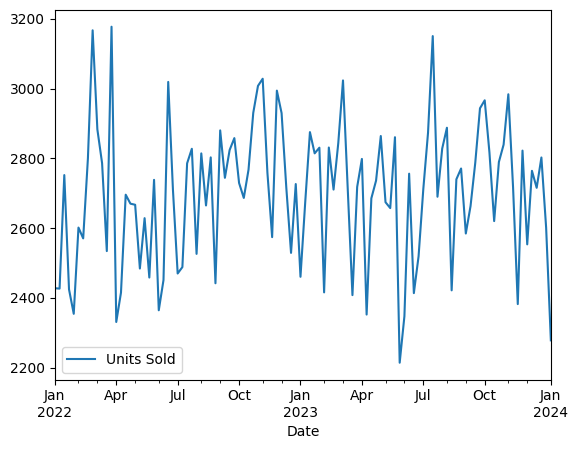

In [ ]:
s1_weekly  = s1.resample('W').mean()
s1_weekly.plot()

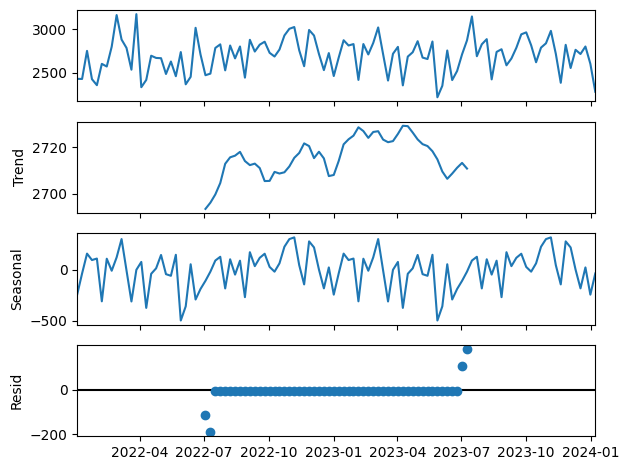

In [ ]:
decomposition = sm.tsa.seasonal_decompose(s1_weekly, model='additive')
decomposition.plot()
plt.show()

## 3.ARIMA

In [ ]:
#dicky fuller test
result = adfuller(s1_weekly['Units Sold'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value:.3f}')

# Interpretation
if result[1] < 0.05:
    print("The series is stationary (reject null hypothesis).")
else:
    print("The series is non-stationary (fail to reject null hypothesis).")

ADF Statistic: -8.691498765047175
p-value: 4.0291227890814694e-14
Critical Values:
   1%: -3.494
   5%: -2.889
   10%: -2.582
The series is stationary (reject null hypothesis).


In [ ]:
# since the data is already stationary we will not do any differencing
# The d value is 0 else do revnue(current) - revnue.shift(1)(previous) d=1
# note :if you have a seasonal data , that is data changing everyyear go for a 12 months difference
s1_weekly['Shift_Units']= s1_weekly['Units Sold'].shift(1)
s1_weekly['diff_units'] = s1_weekly['Units Sold'] - s1_weekly['Shift_Units']
s1_weekly.dropna(inplace=True)
s1_weekly.head()

,Units Sold,Shift_Units,diff_units
Date,,,
2022-01-09,2426.43,2427.50,-1.07
2022-01-16,2752.00,2426.43,325.57
2022-01-23,2424.14,2752.00,-327.86
2022-01-30,2354.14,2424.14,-70.00
2022-02-06,2601.43,2354.14,247.29


In [ ]:
#do dicky fuller test
result = adfuller(s1_weekly['diff_units'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value:.3f}')
if result[1] < 0.05:
    print("The series is stationary (reject null hypothesis).")
else:
    print("The series is non-stationary (fail to reject null hypothesis).")

ADF Statistic: -6.736420657748973
p-value: 3.199022066498537e-09
Critical Values:
   1%: -3.498
   5%: -2.891
   10%: -2.583
The series is stationary (reject null hypothesis).


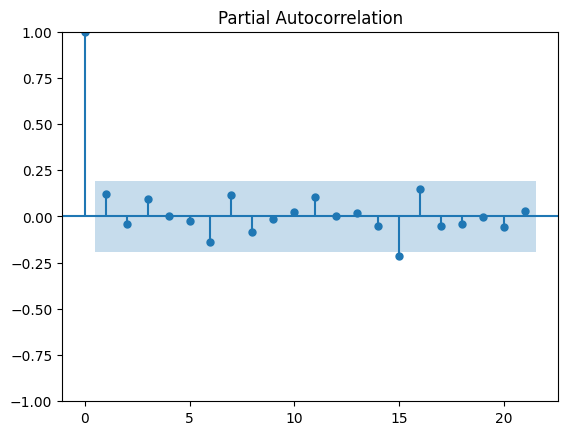

In [ ]:
#any lag going over upper or lower bounds has direct impact
#pearson correlation is used by the plot
#Since data is weekly each lag is 1week ago lag=1 for 1 week ago, lag=2 2week ago
#set the lags = 52, since there are 52 weeks in a year
plot_pacf(s1_weekly['Units Sold'])
plt.show()
#consider  p=1

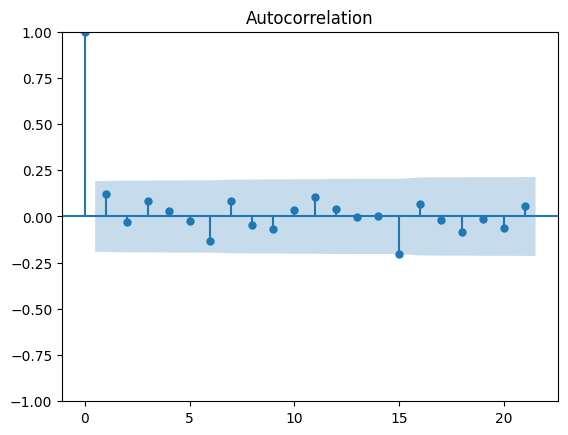

In [ ]:
plot_acf(s1_weekly['Units Sold'])
plt.show()
#q=1

In [ ]:
s1_weekly

,Units Sold,Shift_Units,diff_units
Date,,,
2022-01-09,2426.43,2427.50,-1.07
2022-01-16,2752.00,2426.43,325.57
2022-01-23,2424.14,2752.00,-327.86
2022-01-30,2354.14,2424.14,-70.00
2022-02-06,2601.43,2354.14,247.29
...,...,...,...
2023-12-10,2764.14,2553.29,210.86
2023-12-17,2715.43,2764.14,-48.71
2023-12-24,2802.43,2715.43,87.00


In [ ]:
# Split dataset into train and test
train_size = int(len(s1_weekly) * 0.8)  # 80% train, 20% test
train, test = s1_weekly[:train_size], s1_weekly[train_size:]

# From ACF and PACG p and d value
model = ARIMA(train['Units Sold'], order=(1,0,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Units Sold   No. Observations:                   84
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -566.469
Date:                Mon, 10 Nov 2025   AIC                           1140.938
Time:                        18:28:49   BIC                           1150.661
Sample:                    01-09-2022   HQIC                          1144.846
                         - 08-13-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2694.4645     23.394    115.176      0.000    2648.612    2740.317
ar.L1         -0.9056      0.092     -9.845      0.000      -1.086      -0.725
ma.L1          0.9991      1.244      0.803      0.4

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


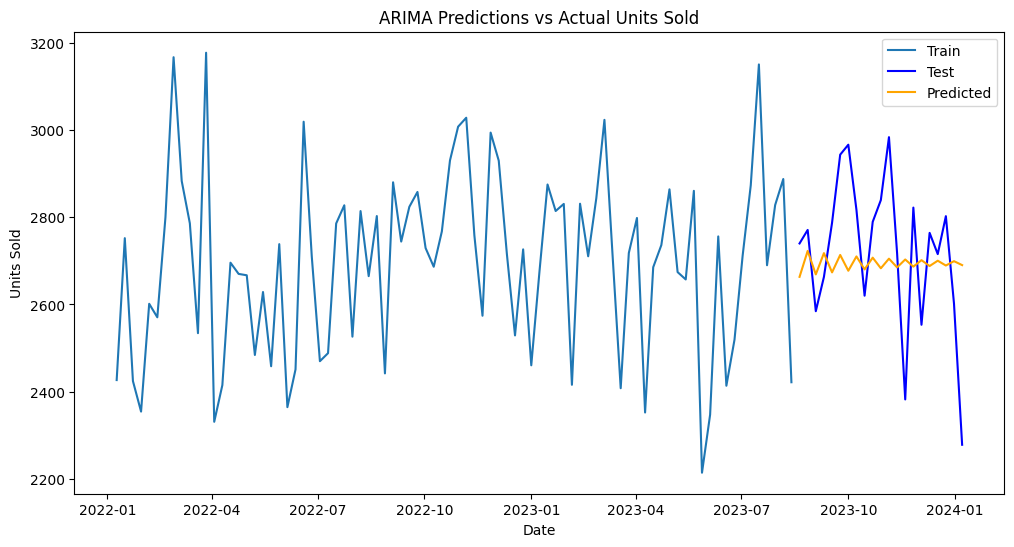

In [ ]:
# extract the first and last date of the test data for prediction
pred_start = test.index[0]
pred_end = test.index[-1]
predictions = model_fit.predict(start=pred_start, end=pred_end, typ='levels')  # typ='levels' for original scale

# Plot Train, test and predicted data
plt.figure(figsize=(12,6))
plt.plot(train['Units Sold'], label='Train')
plt.plot(test['Units Sold'], label='Test', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('ARIMA Predictions vs Actual Units Sold')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# MAE
mae = mean_absolute_error(test['Units Sold'], predictions)

# RMSE
rmse = np.sqrt(mean_squared_error(test['Units Sold'], predictions))

# MAPE (percentage error)
mape = np.mean(np.abs((test['Units Sold'] - predictions) / test['Units Sold'])) * 100

# Combine into dictionary
metrics = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
print(metrics)


{'MAE': 139.654017482413, 'RMSE': np.float64(173.82197633058732), 'MAPE': np.float64(5.231548694793572)}


## 4.SARIMA

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/usr/local/lib/python3.12/dist-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/usr

                                     SARIMAX Results                                      
Dep. Variable:                         Units Sold   No. Observations:                   84
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                   0.000
Date:                            Mon, 10 Nov 2025   AIC                             10.000
Time:                                    18:28:59   BIC                                nan
Sample:                                01-09-2022   HQIC                               nan
                                     - 08-13-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4365         -0        inf      0.000      -0.437      -0.437
ma.L1          0.3272         -0   

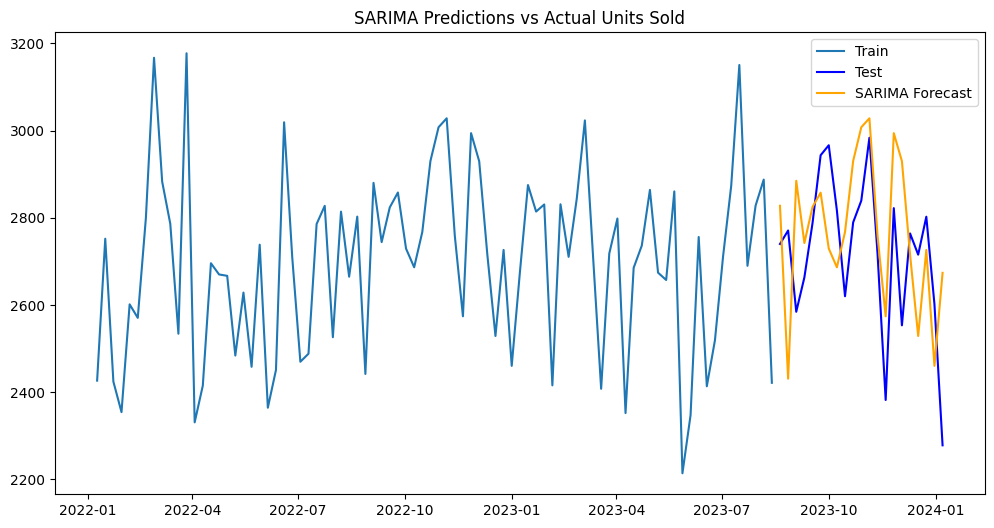

In [ ]:
#Since ARIMA was not accurate in prediction, try Plotting the SARIMA model , give the order and the seasonal order
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(
    train['Units Sold'],
    order=(1,0,1),
    seasonal_order=(1,1,1,52),  # weekly seasonality for yearly cycle (52 weeks)
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = model_sarima.fit()
print(sarima_fit.summary())

# Forecast
sarima_pred = sarima_fit.predict(start=pred_start, end=pred_end, typ='levels')

# Plot
plt.figure(figsize=(12,6))
plt.plot(train['Units Sold'], label='Train')
plt.plot(test['Units Sold'], label='Test', color='blue')
plt.plot(sarima_pred, label='SARIMA Forecast', color='orange')
plt.title('SARIMA Predictions vs Actual Units Sold')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# MAE
mae = mean_absolute_error(test['Units Sold'], sarima_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(test['Units Sold'], sarima_pred))

# MAPE (percentage error)
mape = np.mean(np.abs((test['Units Sold'] - sarima_pred) / test['Units Sold'])) * 100

# Combine into dictionary
metrics = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
print(metrics)


{'MAE': 163.29343844574504, 'RMSE': np.float64(195.5568971898443), 'MAPE': np.float64(6.171882868818551)}


## 5.EWMA

/tmp/ipython-input-899846339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['EWMA'] = train['Units Sold'].ewm(span=4).mean()


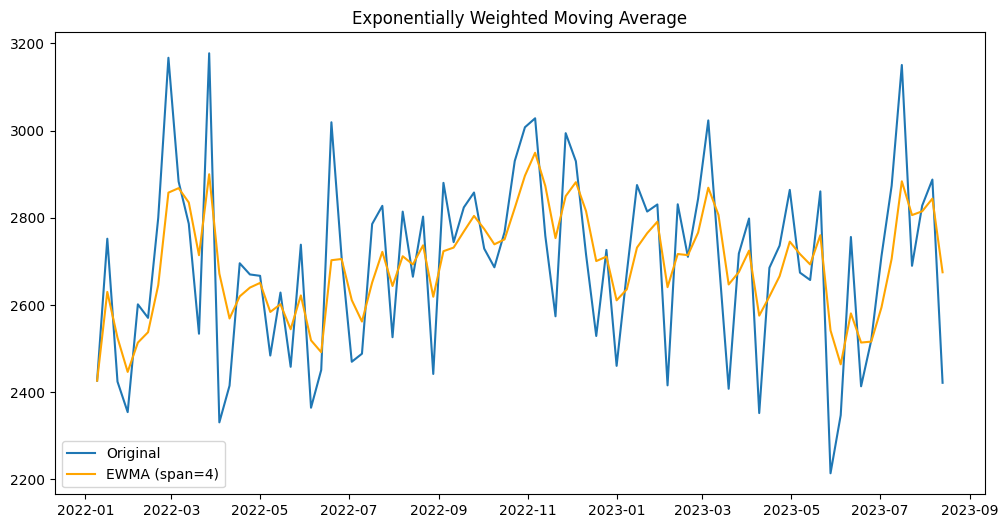

In [ ]:
# Using pandas built-in EWMA
train['EWMA'] = train['Units Sold'].ewm(span=4).mean()

plt.figure(figsize=(12,6))
plt.plot(train['Units Sold'], label='Original')
plt.plot(train['EWMA'], label='EWMA (span=4)', color='orange')
plt.title('Exponentially Weighted Moving Average')
plt.legend()
plt.show()


### Based on the metrics it looks like ARIMA is better than SARIMA , try a different version of ARIMA , like using exog data

## 6.ARIMAX

In [ ]:
# group by different columns
store1.reset_index(inplace=True)
store1.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
arimax_s1 = store1.groupby('Date').aggregate({'Units Sold':'sum','Price':'mean','Holiday/Promotion':'sum',
                                  'Competitor Pricing':'mean','Discount':'mean'})
arimax_s1

,Units Sold,Price,Holiday/Promotion,Competitor Pricing,Discount
Date,,,,,
2022-01-01,2762,50.91,7,51.79,9.25
2022-01-02,2093,48.08,9,47.64,8.00
2022-01-03,2220,64.31,7,64.24,9.00
2022-01-04,2352,58.45,9,58.79,10.25
2022-01-05,1747,60.27,8,59.71,9.75
...,...,...,...,...,...
2023-12-28,2966,56.94,9,57.53,11.50
2023-12-29,2084,57.07,11,57.05,9.25
2023-12-30,2031,64.78,7,64.87,7.25


In [ ]:
#convert the arimax to weekly data
weekly_arimax = arimax_s1.resample('W').mean()
weekly_arimax

,Units Sold,Price,Holiday/Promotion,Competitor Pricing,Discount
Date,,,,,
2022-01-02,2427.50,49.49,8.00,49.71,8.62
2022-01-09,2426.43,55.96,8.71,55.58,9.36
2022-01-16,2752.00,52.71,9.14,52.64,11.07
2022-01-23,2424.14,55.74,9.43,55.88,10.86
2022-01-30,2354.14,58.13,11.14,57.86,9.57
...,...,...,...,...,...
2023-12-10,2764.14,54.53,8.29,54.52,9.93
2023-12-17,2715.43,54.89,9.43,54.82,10.46
2023-12-24,2802.43,52.90,9.57,52.35,9.64


In [ ]:
# Split dataset into train and test
train_size = int(len(weekly_arimax) * 0.8)  # 80% train, 20% test
train, test = weekly_arimax[:train_size], weekly_arimax[train_size:]

# Example: assuming you have an exogenous variable called 'Promo_Spend'
exog_vars = ['Price', 'Holiday/Promotion','Competitor Pricing','Discount']
train_exog = train[exog_vars]
test_exog = test[exog_vars]

pred_start = test_exog.index[0]
pred_end = test_exog.index[-1]
pred_start

Timestamp('2023-08-13 00:00:00')

                               SARIMAX Results                                
Dep. Variable:             Units Sold   No. Observations:                   84
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -566.819
Date:                Mon, 10 Nov 2025   AIC                           1147.638
Time:                        18:29:18   BIC                           1164.485
Sample:                    01-02-2022   HQIC                          1154.402
                         - 08-06-2023                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Price                 81.2489    128.024      0.635      0.526    -169.673     332.171
Holiday/Promotion     -9.9760     40.642     -0.245      0.806     -89.634      69.682
Competitor Pricing  

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


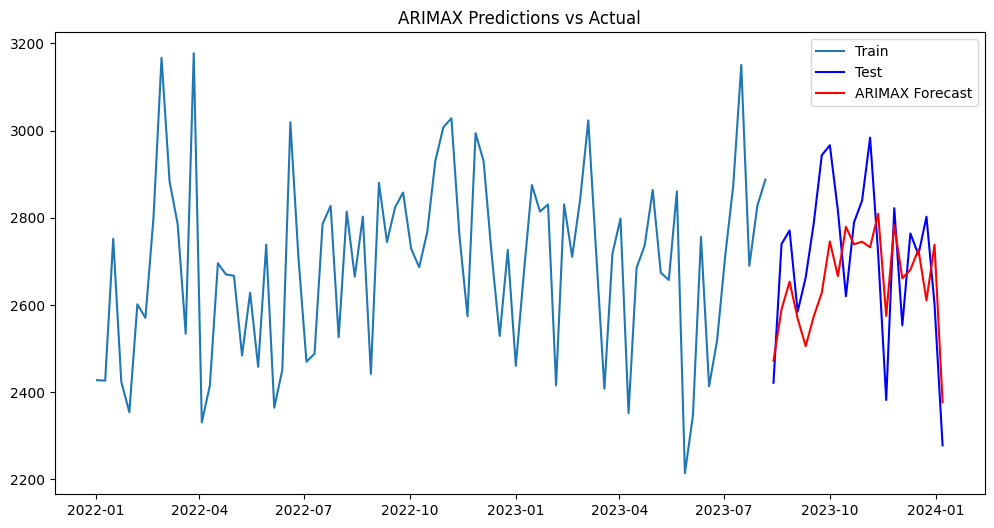

In [ ]:
#since we didnot give the seasonal data and we are giving the exog here this becomes ARIMAX model
model_arimax = SARIMAX(
    train['Units Sold'],
    exog=train_exog,
    order=(1,0,1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

arimax_fit = model_arimax.fit()
print(arimax_fit.summary())

# Forecast with exogenous test data
arimax_pred = arimax_fit.predict(
    start=pred_start,
    end=pred_end,
    exog=test_exog,
    typ='levels'
)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train['Units Sold'], label='Train')
plt.plot(test['Units Sold'], label='Test', color='blue')
plt.plot(arimax_pred, label='ARIMAX Forecast', color='red')
plt.title('ARIMAX Predictions vs Actual')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# MAE
mae = mean_absolute_error(test['Units Sold'], arimax_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(test['Units Sold'], arimax_pred))

# MAPE (percentage error)
mape = np.mean(np.abs((test['Units Sold'] - arimax_pred) / test['Units Sold'])) * 100

# Combine into dictionary
metrics = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
print(metrics)


{'MAE': 131.86155989957092, 'RMSE': np.float64(152.4895073671963), 'MAPE': np.float64(4.8223345858514985)}


### Analysis : Out of all the models, ARIMAX seem to have a lower MAE, RMSE and MAPE. ARIMA had poor performance, since data amight not be entirely dependent on the date. SARIMAX, showed that there is no such seasonality to data. But ARIMAX, has shown that the units sold, depends on other factors like discount, holidays, price and competitors price. ARIMAX will be the finised model for prediction

In [ ]:
df

,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
Date,,,,,,,,,,,,,,
2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter


##7.ARIMAX for units sold across each store

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


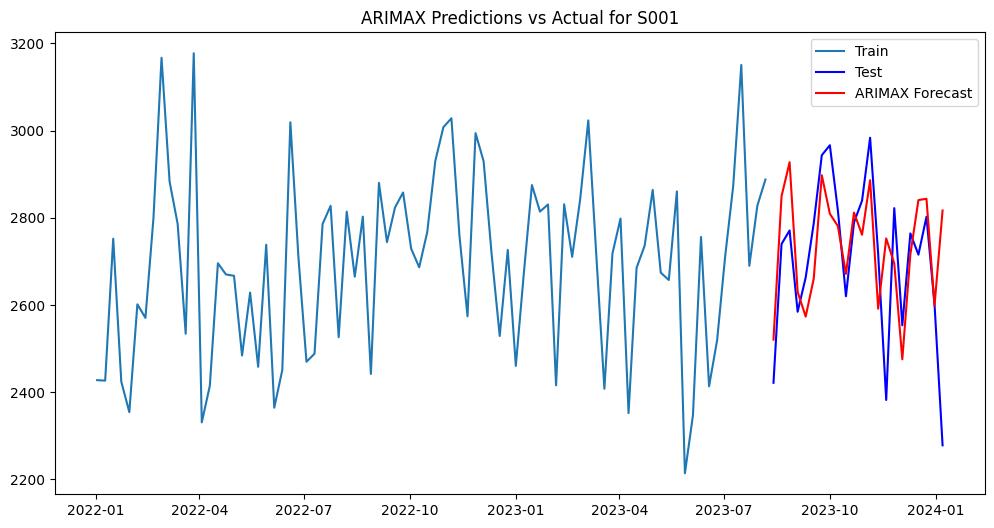

{'MAE': 116.98228886104198, 'RMSE': np.float64(165.8037648095431), 'MAPE': np.float64(4.53079366496537)}


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


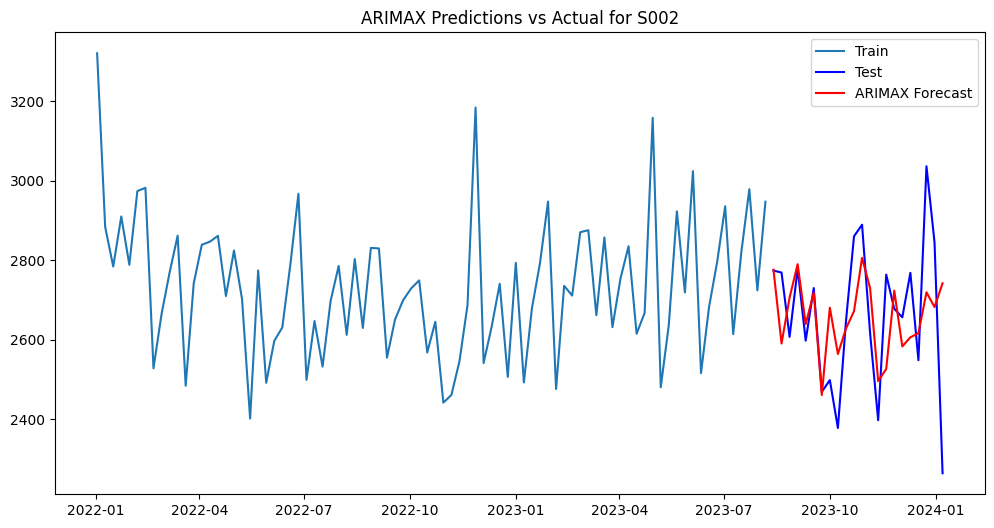

{'MAE': 125.78456598465041, 'RMSE': np.float64(168.89115867501332), 'MAPE': np.float64(4.80330064929854)}


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


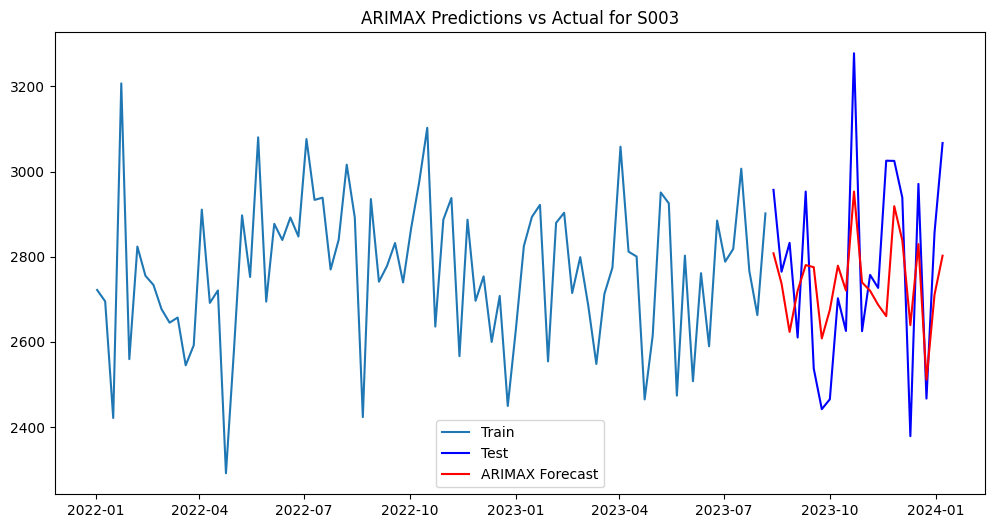

{'MAE': 154.51290597773243, 'RMSE': np.float64(179.5528705557005), 'MAPE': np.float64(5.544109450773789)}


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


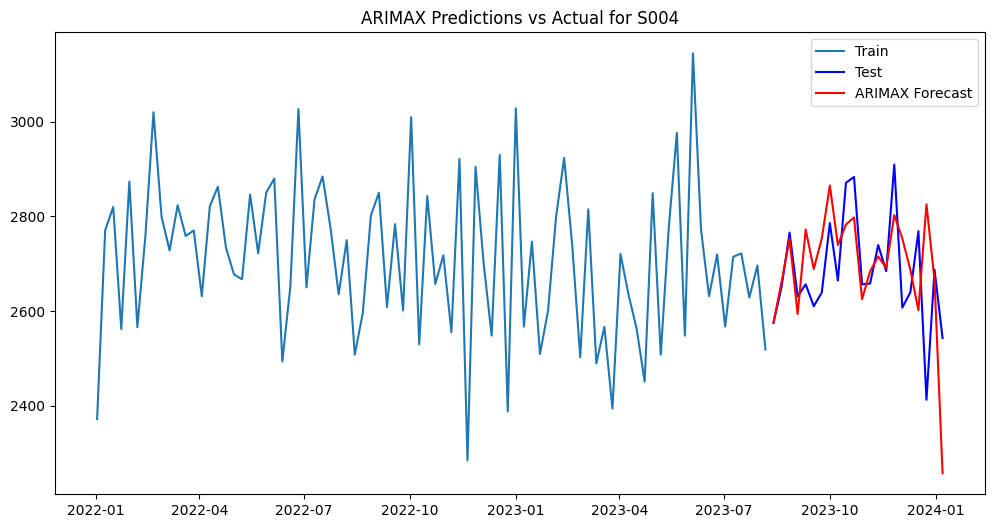

{'MAE': 89.77757269272374, 'RMSE': np.float64(131.30912842245542), 'MAPE': np.float64(3.4227023370910095)}


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


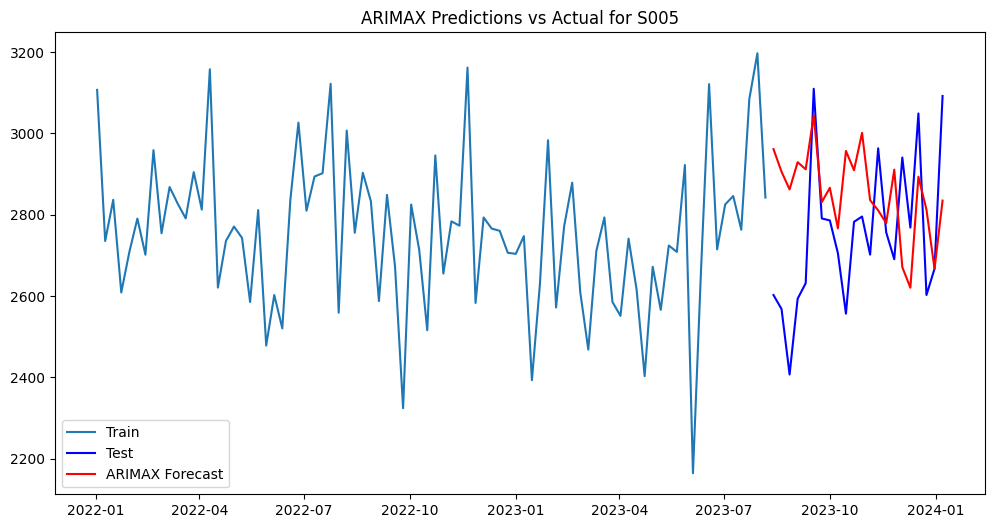

{'MAE': 196.1864328692447, 'RMSE': np.float64(233.02872066097484), 'MAPE': np.float64(7.307923948446389)}


In [ ]:
#get the unique values of the store
store_list = df['Store ID'].unique().tolist()
#print(store_list)
coef_list = []

for i in store_list:

    store  = df[df['Store ID'] == i]
    arimax_s = store.groupby(['Date']).aggregate({'Units Sold':'sum','Price':'mean','Holiday/Promotion':'sum',
    'Competitor Pricing':'mean','Discount':'mean','Units Ordered':'mean','Inventory Level':'mean'})
    weekly_arimax = arimax_s.resample('W').mean()
    # Split dataset into train and test
    # Split dataset into train and test
    train_size = int(len(weekly_arimax) * 0.8)  # 80% train, 20% test
    train, test = weekly_arimax[:train_size], weekly_arimax[train_size:]
    # use the exorg data
    exog_vars = ['Units Ordered','Price', 'Holiday/Promotion','Competitor Pricing','Discount','Inventory Level']
    train_exog = train[exog_vars]
    test_exog = test[exog_vars]

    #Training the model

    model_arimax = SARIMAX(train['Units Sold'],exog=train_exog,
    order=(1,0,2), #seasonal_order=(1,0,1,12),
    enforce_stationarity=False,enforce_invertibility=False)

    arimax_fit = model_arimax.fit()
    #print(arimax_fit.summary())
    # store coefficients in a DataFrame
    coef_df = pd.DataFrame(arimax_fit.params, columns=['Coefficient'])
    coef_df['Store_ID'] = i  # add store ID column
    coef_list.append(coef_df)

    # Predicting  with exogenous test data
    pred_start = test_exog.index[0]
    pred_end = test_exog.index[-1]

    arimax_pred = arimax_fit.predict(
    start=pred_start,
    end=pred_end,
    exog=test_exog,
    typ='levels')

    # Plot Units Sold prediction for each store
    plt.figure(figsize=(12,6))
    plt.plot(train['Units Sold'], label='Train')
    plt.plot(test['Units Sold'], label='Test', color='blue')
    plt.plot(arimax_pred, label='ARIMAX Forecast', color='red')
    plt.title(f'ARIMAX Predictions vs Actual for {i}')
    plt.legend()
    plt.show()

    #Plot the mertics for predcition
    # MAE
    mae = mean_absolute_error(test['Units Sold'], arimax_pred)

    # RMSE
    rmse = np.sqrt(mean_squared_error(test['Units Sold'], arimax_pred))

    # MAPE (percentage error)
    mape = np.mean(np.abs((test['Units Sold'] - arimax_pred) / test['Units Sold'])) * 100

    # Combine into dictionary
    metrics = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
    print(metrics)



## 8.What-Ifs

### Understand how the unit sold changes when the cofficients like price, promotions, discount changes (negativey/positively).

###  For example store1
  1. A 1-unit increase in discount reduces units sold by 7.36 → negative
  2. As your price increases by 1 unit, units sold go up by 100.35

In [ ]:
coef_list

[                    Coefficient Store_ID
 Units Ordered              2.13     S001
 Price                     97.69     S001
 Holiday/Promotion        -51.28     S001
 Competitor Pricing      -101.01     S001
 Discount                 -14.93     S001
 Inventory Level           12.09     S001
 ar.L1                     -0.69     S001
 ma.L1                      0.83     S001
 ma.L2                     -0.07     S001
 sigma2                 22102.21     S001,
                     Coefficient Store_ID
 Units Ordered              6.81     S002
 Price                     13.29     S002
 Holiday/Promotion         35.82     S002
 Competitor Pricing       -18.56     S002
 Discount                 -38.36     S002
 Inventory Level            8.30     S002
 ar.L1                      0.86     S002
 ma.L1                     -0.96     S002
 ma.L2                      0.14     S002
 sigma2                 18899.69     S002,
                     Coefficient Store_ID
 Units Ordered             -0.45

In [ ]:
#What if the dicount price is increased by 10%
discount_up = test_exog.copy()
discount_up['Discount'] = discount_up['Discount'] * 1.10
#predict the test dataframe with 10% increase in discount
discount_pred = arimax_fit.predict(
    start=test_exog.index[0],
    end=test_exog.index[-1],
    exog=discount_up,
    typ='levels'
)
#subtract the difference between discount_pred and original predictions
impact_discount = discount_pred - arimax_pred
print(f"Avg change if discount +10%: {impact_discount.mean():.2f} units")


Avg change if discount +10%: 38.61 units


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
#What if the price is reduced by 5%
price_down = test_exog.copy()
price_down['Price'] = price_down['Price'] * 0.95

price_pred = arimax_fit.predict(
    start=test_exog.index[0],
    end=test_exog.index[-1],
    exog=price_down,
    typ='levels'
)

impact_price = price_pred - arimax_pred
print(f"Avg change if price -5%: {impact_price.mean():.2f} units")


Avg change if price -5%: 64.06 units


In [ ]:
#what if the competitor price is reduced by 5%
comp_down = test_exog.copy()
comp_down['Competitor Pricing'] = comp_down['Competitor Pricing'] * 0.95

comp_pred = arimax_fit.predict(
    start=test_exog.index[0],
    end=test_exog.index[-1],
    exog=comp_down,
    typ='levels'
)

impact_comp = comp_pred - arimax_pred
print(f"Avg change if competitor price -5%: {impact_comp.mean():.2f} units")
#makes sense , if competition price is reduce then less people will buy from this store meaning less products are sold

Avg change if competitor price -5%: -74.99 units


In [ ]:
#what if there were no promotions?
promo_up = test_exog.copy()
promo_up['Holiday/Promotion'] = 0  # simulate promo active every week

promo_pred = arimax_fit.predict(
    start=test_exog.index[0],
    end=test_exog.index[-1],
    exog=promo_up,
    typ='levels'
)

impact_promo = promo_pred - arimax_pred
print(f"Avg change if promotion active: {impact_promo.mean():.2f} units")


Avg change if promotion active: 58.51 units


In [ ]:
whatif_summary = pd.DataFrame({
    'Scenario': ['Base', 'Discount +10%', 'Price -5%', 'Competitor -5%', 'Promo Active'],
    'Avg_Units_Sold': [
        arimax_pred.mean(),
        discount_pred.mean(),
        price_pred.mean(),
        comp_pred.mean(),
        promo_pred.mean()
    ]
})

whatif_summary['%_Change_vs_Base'] = (
    (whatif_summary['Avg_Units_Sold'] - whatif_summary['Avg_Units_Sold'][0]) /
    whatif_summary['Avg_Units_Sold'][0] * 100
)

print(whatif_summary)


         Scenario  Avg_Units_Sold  %_Change_vs_Base
0            Base         2853.75              0.00
1   Discount +10%         2892.36              1.35
2       Price -5%         2917.80              2.24
3  Competitor -5%         2778.75             -2.63
4    Promo Active         2912.25              2.05


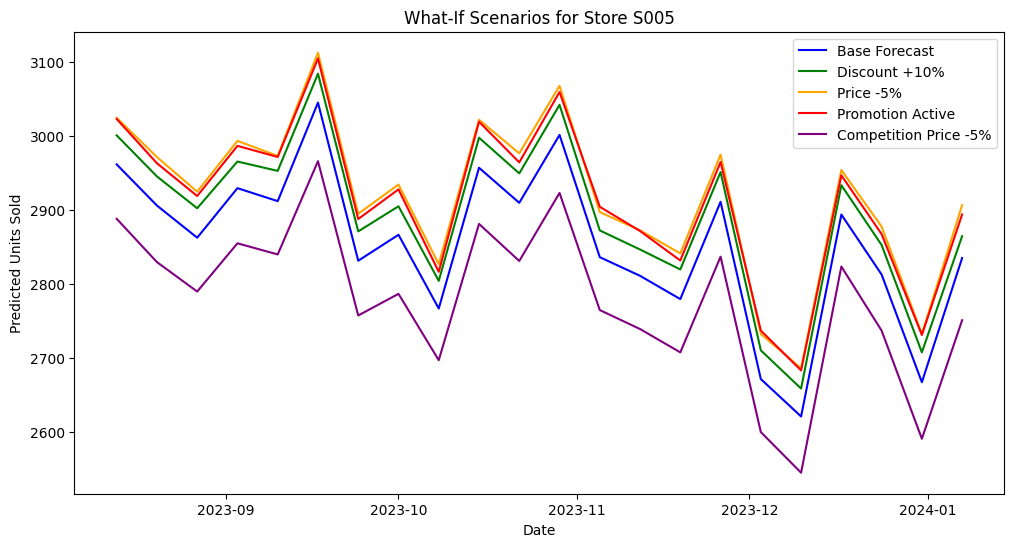

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(arimax_pred, label='Base Forecast', color='blue')
plt.plot(discount_pred, label='Discount +10%', color='green')
plt.plot(price_pred, label='Price -5%', color='orange')
plt.plot(promo_pred, label='Promotion Active', color='red')
plt.plot(comp_pred, label ='Competition Price -5%', color='purple')
plt.title(f"What-If Scenarios for Store {i}")
plt.xlabel("Date")
plt.ylabel("Predicted Units Sold")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


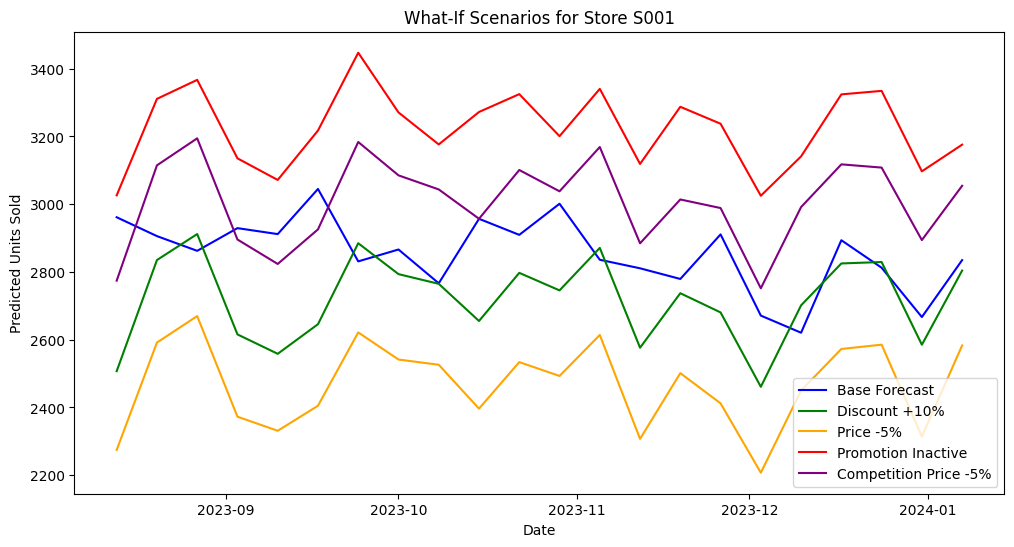

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


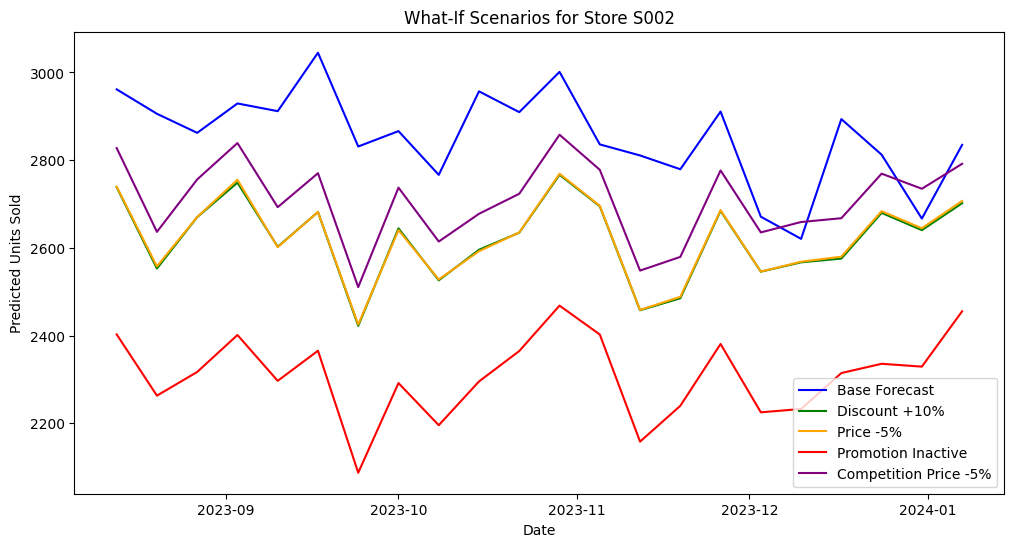

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


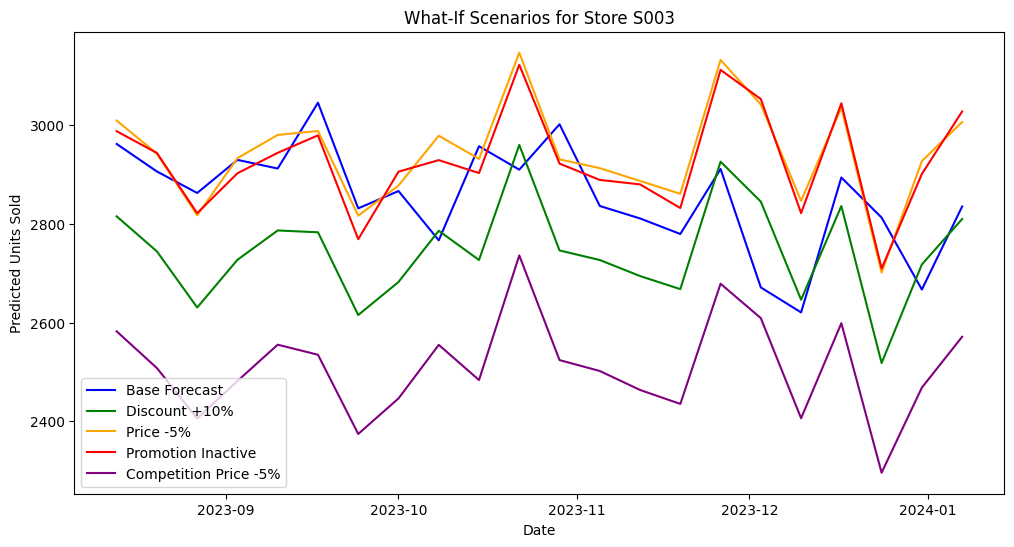

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


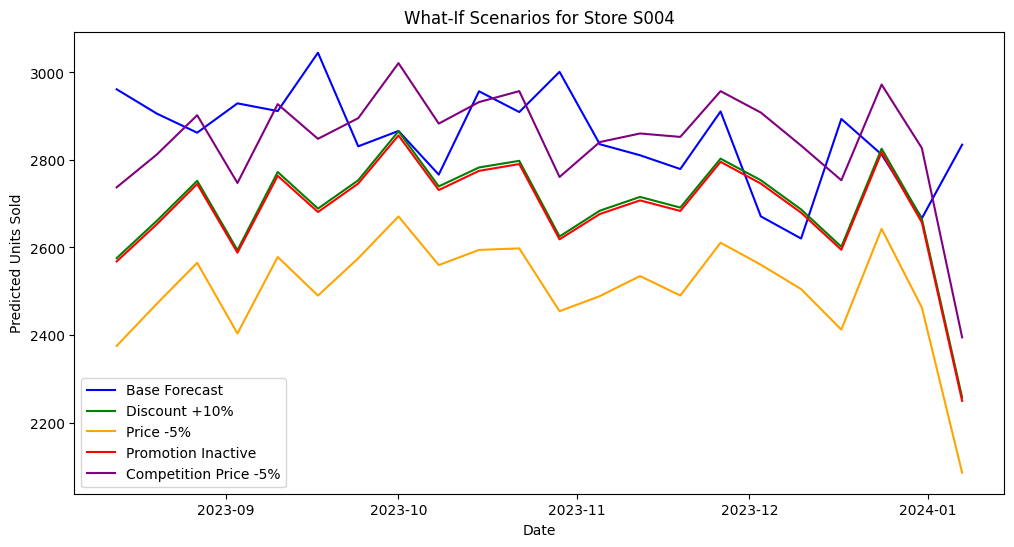

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


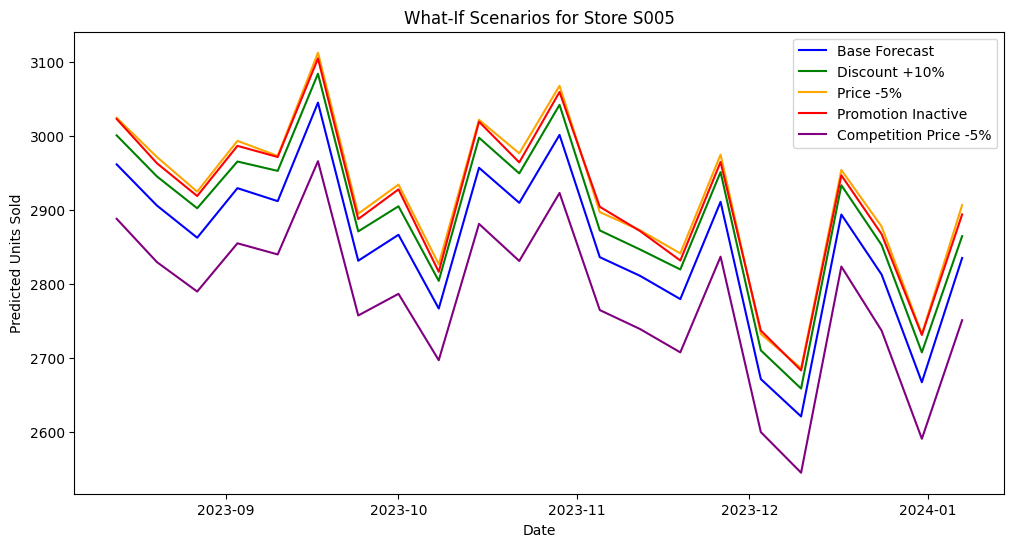

In [ ]:
#Automate What-If scenarios
#What if the dicount price is increased by 10%, price is reduced by 5%, competitor price is reduced by 5%, the promotions were 0

#get the unique values of the store
store_list = df['Store ID'].unique().tolist()
#print(store_list)
coef_list = []
all_summaries = []

for i in store_list:

    store  = df[df['Store ID'] == i]
    arimax_s = store.groupby(['Date']).aggregate({'Units Sold':'sum','Price':'mean','Holiday/Promotion':'sum',
    'Competitor Pricing':'mean','Discount':'mean','Units Ordered':'mean','Inventory Level':'mean'})
    weekly_arimax = arimax_s.resample('W').mean()
    # Split dataset into train and test
    train_size = int(len(weekly_arimax) * 0.8)  # 80% train, 20% test
    train, test = weekly_arimax[:train_size], weekly_arimax[train_size:]
    # use the exorg data
    exog_vars = ['Units Ordered','Price', 'Holiday/Promotion','Competitor Pricing','Discount','Inventory Level']
    train_exog = train[exog_vars]
    test_exog = test[exog_vars]

    #Training the model

    model_arimax = SARIMAX(train['Units Sold'],exog=train_exog,
    order=(1,0,2),
    enforce_stationarity=False,enforce_invertibility=False)

    arimax_fit = model_arimax.fit()
    #print(arimax_fit.summary())

    # Predicting  with exogenous test data
    pred_start = test_exog.index[0]
    pred_end = test_exog.index[-1]

    #predict the test dataframe with 10% increase in discount
    discount_up = test_exog.copy()
    discount_up['Discount'] = discount_up['Discount'] * 1.10

    discount_pred = arimax_fit.predict(
    start=test_exog.index[0],
    end=test_exog.index[-1],
    exog=discount_up,
    typ='levels'
    )
    #What if the price is reduced by 5%
    price_down = test_exog.copy()
    price_down['Price'] = price_down['Price'] * 0.95

    price_pred = arimax_fit.predict(
    start=test_exog.index[0],
    end=test_exog.index[-1],
    exog=price_down,
    typ='levels'
    )
    #what if the competitor price is reduced by 5%
    comp_down = test_exog.copy()
    comp_down['Competitor Pricing'] = comp_down['Competitor Pricing'] * 0.95

    comp_pred = arimax_fit.predict(
    start=test_exog.index[0],
    end=test_exog.index[-1],
    exog=comp_down,
    typ='levels'
    )

    #what if there were no promotions?
    promo_up = test_exog.copy()
    promo_up['Holiday/Promotion'] = 0  # simulate promo active every week

    promo_pred = arimax_fit.predict(
    start=test_exog.index[0],
    end=test_exog.index[-1],
    exog=promo_up,
    typ='levels'
    )

    #Append to the summary table
    whatif_summary = pd.DataFrame({
    'Scenario': ['Base', 'Discount +10%', 'Price -5%', 'Competitor -5%', 'Promo Active'],
    'Avg_Units_Sold': [
        arimax_pred.mean(),
        discount_pred.mean(),
        price_pred.mean(),
        comp_pred.mean(),
        promo_pred.mean()
    ]
      } )

    whatif_summary['%_Change_vs_Base'] = (
    (whatif_summary['Avg_Units_Sold'] - whatif_summary['Avg_Units_Sold'][0]) /
    whatif_summary['Avg_Units_Sold'][0] * 100
    )

    # Add Store ID column
    whatif_summary['Store_ID'] = i

    # Append to list
    all_summaries.append(whatif_summary)



    # Plot Units Sold base line prediction vs What if senarios for each store
    plt.figure(figsize=(12,6))
    plt.plot(arimax_pred, label='Base Forecast', color='blue')
    plt.plot(discount_pred, label='Discount +10%', color='green')
    plt.plot(price_pred, label='Price -5%', color='orange')
    plt.plot(promo_pred, label='Promotion Inactive', color='red')
    plt.plot(comp_pred, label ='Competition Price -5%', color='purple')
    plt.title(f"What-If Scenarios for Store {i}")
    plt.xlabel("Date")
    plt.ylabel("Predicted Units Sold")
    plt.legend()
    plt.show()





In [ ]:
all_summaries

[         Scenario  Avg_Units_Sold  %_Change_vs_Base Store_ID
 0            Base         2853.75              0.00     S001
 1   Discount +10%         2717.48             -4.78     S001
 2       Price -5%         2468.27            -13.51     S001
 3  Competitor -5%         3004.95              5.30     S001
 4    Promo Active         3222.81             12.93     S001,
          Scenario  Avg_Units_Sold  %_Change_vs_Base Store_ID
 0            Base         2853.75              0.00     S002
 1   Discount +10%         2618.92             -8.23     S002
 2       Price -5%         2620.69             -8.17     S002
 3  Competitor -5%         2708.30             -5.10     S002
 4    Promo Active         2310.15            -19.05     S002,
          Scenario  Avg_Units_Sold  %_Change_vs_Base Store_ID
 0            Base         2853.75              0.00     S003
 1   Discount +10%         2744.85             -3.82     S003
 2       Price -5%         2940.68              3.05     S003
 3  Co

In [ ]:
#combine the list into data frame
final_summary = pd.concat(all_summaries, ignore_index=True)


In [ ]:
final_summary

,Scenario,Avg_Units_Sold,%_Change_vs_Base,Store_ID
0,Base,2853.75,0.00,S001
1,Discount +10%,2717.48,-4.78,S001
2,Price -5%,2468.27,-13.51,S001
3,Competitor -5%,3004.95,5.30,S001
4,Promo Active,3222.81,12.93,S001
5,Base,2853.75,0.00,S002
6,Discount +10%,2618.92,-8.23,S002
7,Price -5%,2620.69,-8.17,S002
8,Competitor -5%,2708.30,-5.10,S002
9,Promo Active,2310.15,-19.05,S002


In [ ]:
final_summary.pivot_table(index='Store_ID', columns='Scenario', values='%_Change_vs_Base')

Scenario,Base,Competitor -5%,Discount +10%,Price -5%,Promo Active
Store_ID,,,,,
S001,0.00,5.30,-4.78,-13.51,12.93
S002,0.00,-5.10,-8.23,-8.17,-19.05
S003,0.00,-12.05,-3.82,3.05,2.56
S004,0.00,-0.25,-5.56,-12.19,-5.83
S005,0.00,-2.63,1.35,2.24,2.05


## 9.What If Insights

1. Price Sensitivity (−5% price)

Store 3 shows +3% uplift in units sold -> indicates customers are highly price-sensitive.

Store 1 sees −14% drop -> potential over-reaction or possible overpricing perception; avoid further price cuts there.

2. Promotion Influence (removing promotions)

Store 1 gains +13% sales when promotions are stopped -> discounts may be unnecessary or even cannibalizing margin.

Store 2 drops −19% -> heavy dependency on promotions; revenue stability could suffer if promos are reduced.

3. Discount Effect (+10% discount)

Store 5 sees a modest +1% increase -> low responsiveness, discounts may not justify cost.

Store 2 falls −8%, suggesting discount saturation or customer fatigue.

4. Competitor Price Reaction (−5% competitor price)

Store 1 benefits +5%, implying cross-price elasticity, it's positioned well vs. competitors.

Store 3 loses −12%, meaning it's highly exposed to competitor pricing; defensive pricing strategy recommended.